## Set to directory with python scripts

In [1]:
%cd '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts'

/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts


## Load modules

In [2]:
import re
import glob
import ast
import shap
import scipy.stats as st
from collections import Counter
import sklearn
from matplotlib import cm
import scipy
import itertools
from datetime import datetime
from seaborn import clustermap
from scipy.cluster.hierarchy import linkage
from sklearn.linear_model import LogisticRegression
import os
import time
import pickle as pkl

from helper import *
from dataLoader import *
from basic_data_methods_helper import *
from heatmaps_helper import *

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

# Base directory figure folders will be saved in 
base_path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'

## Load data

In [59]:
# set data_path to point to directory with data
data_path = "/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Data/"

# Option to change filtering criteria
dl = dataLoader(path = data_path, pt_perc = {'metabs': .25, '16s': .1, 'scfa': 0, 'toxin':0}, meas_thresh = 
                {'metabs': 0, '16s': 10, 'scfa': 0, 'toxin':0}, 
                var_perc = {'metabs': 50, '16s': 5, 'scfa': 0, 'toxin':0}, pt_tmpts = 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Calculate AUCs and feature selections for all results in given folder

In [3]:
# Set path to where predictive analysis results are 
path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/'
path2 = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'

with open(path + 'aucs.pkl', 'rb') as f:
    auc_all = pkl.load(f)
    
for method in os.listdir(path):
    in_path = path + method + '/'
#     if len(method.split('_'))==2:
#         continue
    if not os.path.isdir(in_path):
        continue
        
    if method in auc_all.keys():
        ls = list(auc_all['cox2_week1.0'].keys())
        ls.remove('demo')
        if len(ls)>=5:
            for folder in os.listdir(in_path):
                if not os.path.isdir(in_path +  folder):
                    continue
                if len(os.listdir(in_path + folder)) == 0:
                    continue
                if 'coefs.csv' not in os.listdir(in_path + folder):
                    get_coefs(in_path, folder)
                    print('coefs in ' + in_path + folder)
            continue
        else:
            print(method)
            print(set(auc_all[method].keys()))
    if 'DS' in method:
        continue

    final_res_dict = {}
    
    for folder in os.listdir(in_path):
        if not os.path.isdir(in_path  + folder):
            continue
        final_res_dict[folder] = {}
        for file in os.listdir(in_path + folder):
            if 'pkl' not in file:
                continue
            if file == '.DS_Store':
                continue
            try:
                with open(in_path + folder + '/' + file, 'rb') as f:
                        # temp is a dictionary with parameter keys 
                    temp = pkl.load(f)
            except:
                print('PICKLE ERROR')
                print(in_path + folder + '/' + file)
                break
            try:
                ix = int(file.split('_')[-1].split('.')[0])
            except:
                final_res_dict[folder] = temp

            final_res_dict[folder][ix] = temp

    auc_dict = get_auc_df(final_res_dict, in_path )
    auc_all[method] = auc_dict
    print('performance results in ' + in_path)
    
    for folder in os.listdir(in_path):
        if not os.path.isdir(in_path +  folder):
            continue
        if len(os.listdir(in_path + folder)) == 0:
            continue
        if 'coefs.csv' not in os.listdir(in_path + folder):
            get_coefs(in_path, folder)
            print('coefs in ' + in_path + folder)
    
with open(path + 'aucs.pkl', 'wb') as f:
    pkl.dump(auc_all, f)

/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/scfa
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/scfa
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/demo
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/demo
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/16s
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/16s
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/metabs
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/metabs
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/metabs_16s_sc

coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/demo
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/16s
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/16s
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/metabs
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/metabs
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/metabs_16s_scfa_toxin_demo
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/metabs_16s_scfa_toxin_demo
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/toxin
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnal

# If results have already been analyzed, just load the AUC pickle file 

In [8]:
path = base_path + 'PredictiveAnalysisResults/'

with open(path + 'aucs.pkl', 'rb') as f:
    auc_all = pkl.load(f)

## Create supplemental table 4 with predictive analysis results

In [4]:
from string import ascii_uppercase
path_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Supplemental Tables/'
path2 = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'

out_dict = {}
data_dict = {}
i=0
for key in auc_all.keys():
    keyl = key.split('_')
    if len(keyl)>2:
        continue
    for kk in auc_all[key].keys():
        keyl.append(kk.replace('_','+'))
        temp = auc_all[key][kk].copy()
        sc = pd.DataFrame(temp['data'])
        temp_dat = np.empty(48)
        temp_dat[:] = np.nan
        temp_dat[np.arange(len(sc))] = sc.values.squeeze()
        data_dict[tuple(keyl)] = temp_dat
        del temp['data']
        out_dict[tuple(keyl)] = temp
        keyl.pop(-1)
        i += 1
df_dat = pd.DataFrame(data_dict).T.sort_index().T
df = pd.DataFrame(out_dict).T
df = df.sort_index()
path_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Supplemental Tables/'
with pd.ExcelWriter(path_save + 'Table 4. Predictive Results.xlsx', mode = 'w') as writer:
    df.to_excel(writer, sheet_name = 'A. Results')
    
    
with pd.ExcelWriter(path_save + 'Table 4. Predictive Results.xlsx', mode = 'a') as writer:
    df_dat.to_excel(writer, sheet_name = 'B. Data')

## Move & rename csvs

In [4]:
path2 = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'

# Folder with predictive analysis results
path = 'PredictiveAnalysisResults/'
if not os.path.isdir(path2 + 'predictive_feature_tables'):
    os.mkdir(path2 + 'predictive_feature_tables')
for method in os.listdir(path2 + path):
    if 'DS' in method:
        continue
    in_path = path2 + path + method + '/'

    if not os.path.isdir(in_path):
        continue
    auc_dict = auc_all[method]
    coef_res_dict = {}
    for folder in os.listdir(in_path):
        print(in_path + folder)
        if not os.path.isdir(in_path +  folder):
            continue
        csv_files = glob.glob(os.path.join(in_path + folder, '*.csv'))
        if len(csv_files)>0:
            for csv_file in csv_files:
                if len(method.split('_')) == 5:
                    nm = 'joint'
                else:
                    nm = method.split('_')[1]
                new_dir = path2 + 'predictive_feature_tables/' + folder + '_' + nm+ '/'
#                 print(new_dir)
                if not os.path.isdir(new_dir):
                    os.mkdir(new_dir)
                os.rename(csv_file, new_dir + method.split('_')[0] + '-' + 
                          str(np.round(auc_dict[folder]['Median'], 3)).replace('.','')[:4] + '.csv')

/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/scfa
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/demo
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/16s
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/.DS_Store
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/scfa.txt
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/16s.txt
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/metabs
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/metabs_16s_scfa_toxin_demo
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/toxin
/Users/jen

## Save feature selections/coefficients/importances to Supplemental Table 5

In [6]:
from string import ascii_uppercase
path_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Supplemental Tables/'
path2 = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'
taxa_labels = pd.read_csv(path2 + 'scripts/inputs/' + 'taxa_labels.csv', index_col = [0])

ii = 5
idict = {}
tname = {}
df_out = {}
for folder in os.listdir(path2 + 'predictive_feature_tables/'):
    fname = '-'.join(folder.split('_')[:-1])
    if folder == '.DS_Store':
        continue
    if 'slope' in folder:
        continue
    if fname not in tname.keys():
        ii += 1
        tname[fname]  = ii
#     print(tname)
    if fname not in df_out.keys():
        df_out[fname] = {}
    table_name = path_save + 'Table ' + str(tname[fname]) + ' - ' + fname.capitalize() + ' Predictive Analysis.xlsx'
    timepoint = folder.split('_')[-1].capitalize()
    for file in os.listdir(path2 + 'predictive_feature_tables/' + folder):
        if file == '.DS_Store':
            continue
        sigfeats = pd.read_csv(path2 + 'predictive_feature_tables/' + folder + '/' + file, index_col = 0)
        
        label = file.split('.')[0] + ' ' + timepoint
        
        sigfeats = sigfeats.loc[sigfeats.iloc[:,0]!=1, :]
        
        
        if '16s' in fname:
            seqs = list(set(sigfeats.index.values).intersection(taxa_labels['taxa_rdp'].index.values))
            sigfeats['Taxonomy-RDP'] = np.zeros(len(sigfeats.index.values))
#             sequences = sigfeats.index.values
            sigfeats['Taxonomy-RDP'].loc[seqs] = taxa_labels['taxa_rdp'].loc[seqs]
#             sigfeats['Taxonomy-Silva'] = taxa_labels['taxa_silva'].loc[sigfeats.index.values]
            sigfeats['Labels'] = sigfeats.index.values
            sigfeats['Labels'].loc[seqs] = taxa_labels['labels'].loc[seqs]
            sigfeats = sigfeats.set_index('Labels')
#             sigfeats['Sequences'] = sequences
            
        for ix in sigfeats.index.values:
            df_out[fname][(label.split(' ')[1], label.split(' ')[0], ix)] = sigfeats.loc[ix].to_dict()
            
for f in df_out.keys():
    df = pd.DataFrame(df_out[f]).T.sort_index()
    if os.path.exists(path_save + 'Table 5. Predictive Features.xlsx'):
        with pd.ExcelWriter(path_save + 'Table 5. Predictive Features.xlsx',mode ='a') as writer:
            df.to_excel(writer, sheet_name = f)
            
    else:
        with pd.ExcelWriter(path_save + 'Table 5. Predictive Features.xlsx') as writer:
            df.to_excel(writer, sheet_name = f)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [9]:
from string import ascii_uppercase
path_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Data/Predictive Analyses/'
path2 = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'
taxa_labels = pd.read_csv(path2 + 'scripts/inputs/' + 'taxa_labels.csv', index_col = [0])

ii = 5
idict = {}
tname = {}
df_out = {}
for folder in os.listdir(path2 + 'predictive_feature_tables/'):
    fname = '-'.join(folder.split('_')[:-1])
    df_out[fname] = {}
    if folder == '.DS_Store':
        continue
    if fname not in tname.keys():
        ii += 1
        tname[fname]  = ii
#     print(tname)
    table_name = path_save + 'Table ' + str(tname[fname]) + ' - ' + fname.capitalize() + ' Predictive Analysis.xlsx'
    timepoint = folder.split('_')[-1].capitalize()
    for file in os.listdir(path2 + 'predictive_feature_tables/' + folder):
        if file == '.DS_Store':
            continue
        sigfeats = pd.read_csv(path2 + 'predictive_feature_tables/' + folder + '/' + file, index_col = 0)
        
        label = file.split('.')[0] + ' ' + timepoint
        
        if '16s' in fname:
            seqs = list(set(sigfeats.index.values).intersection(taxa_labels['taxa_rdp'].index.values))
            sigfeats['Taxonomy-RDP'] = np.zeros(len(sigfeats.index.values))
#             sequences = sigfeats.index.values
            sigfeats['Taxonomy-RDP'].loc[seqs] = taxa_labels['taxa_rdp'].loc[seqs]
#             sigfeats['Taxonomy-Silva'] = taxa_labels['taxa_silva'].loc[sigfeats.index.values]
            sigfeats['Labels'] = sigfeats.index.values
            sigfeats['Labels'].loc[seqs] = taxa_labels['labels'].loc[seqs]
            sigfeats = sigfeats.set_index('Labels')
#             sigfeats['Sequences'] = sequences
            
        for ix in sigfeats.index.values:
            df_out[fname][(label, ix)] = sigfeats.loc[ix].to_dict()
        
        if table_name not in idict and os.path.exists(table_name):
            os.remove(table_name)
        if os.path.exists(table_name):
            idict[table_name] += 1
            nm = ascii_uppercase[idict[table_name]]
            with pd.ExcelWriter(table_name, mode = 'a') as writer:
                sigfeats.to_excel(writer, sheet_name = nm + '.' + label)
        else:
            idict[table_name] = 0
            nm = ascii_uppercase[idict[table_name]]
            with pd.ExcelWriter(table_name) as writer:
                sigfeats.to_excel(writer, sheet_name = nm + '.' + label)

# Plot figure 5

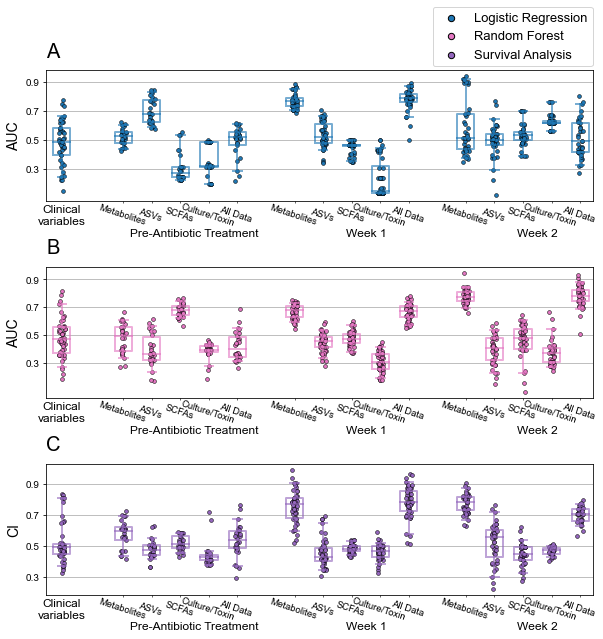

In [58]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

auc_split = {}
for k, v in auc_all.items():
    method, week = k.split('_week')
    if week not in auc_split.keys():
        auc_split[week] = {}
    for kk, vv in v.items():
        if len(kk.split('_'))==5:
            kk = 'joint'
        if kk not in auc_split[week].keys():
            auc_split[week][kk] = {}
        auc_split[week][kk][method] = vv

fig, ax = plt.subplots(3,1,figsize = (8.5,8.5))

cmap = plt.get_cmap('tab20')
# fig, ax = plt.subplots(figsize = (14,5))
i=0
p={}
k = 0
j = 0
colors = {'LR':'tab:blue','RF':'tab:pink','cox2':'tab:purple'}
out_colors = {}
xmaj = []
xstart = -2
xmin = []
lines = []
for i,model in enumerate(['LR','RF','cox2']):
    xminor = []
    xmajor = []
    xloc = -2.15
    dat = auc_split['1.0']['demo'][model]['data']
    xmajor.append(xloc)
    p = ax[i].boxplot(dat, positions = [xloc], widths = 0.6,whis=[5, 95],showfliers=False)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(p[element], color=colors[model], linewidth = 2, alpha = 0.6)

    ax[i].scatter([xloc]*len(dat) + np.random.uniform(-1,1, size = len(dat))*.1, dat, 
                  marker = 'o', color = colors[model], s = 15, alpha = 1, edgecolors = 'black',linewidths = 0.5)
    for week in ['0.0','1.0','2.0']:
        for k, dattype in enumerate(['metabs','16s','scfa','toxin','joint']):
            xloc = float(week)*5 + k + float(week)
            dat = auc_split[week][dattype][model]['data']
            p = ax[i].boxplot(dat, positions = [xloc], widths = 0.6,whis=[5, 95],showfliers=False)
            for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(p[element], color=colors[model], linewidth = 2, alpha = 0.6
#                          , zorder = -1
                        )
                
            ax[i].scatter([xloc]*len(dat) + np.random.uniform(-1,1, size = len(dat))*.1, dat, 
                          marker = 'o', color = colors[model], s = 15, alpha = 1, 
                          edgecolors = 'black',linewidths = 0.5)
            
            xminor.append(xloc)
        xmajor.append(float(week)*5 + float(week) + 2.5)
        
    ax[i].set_xlim(left = -2.70, right = xminor[-1] + 0.45)
    ax[i].set_yticks([0.3,0.5,0.7,0.9])
    ax[i].set_yticklabels([0.3,0.5,0.7,0.9],fontsize = 10)
    if model != 'cox2':
        ax[i].set_ylabel('AUC', fontsize = 14)
    else:
        ax[i].set_ylabel('CI', fontsize = 14)

    ax[i].set_xticks(xmajor)
    ax[i].set_xticklabels(['Clinical\nvariables', '\n\nPre-Antibiotic Treatment', '\n\nWeek 1', '\n\nWeek 2'], fontsize = 12)
    #                     '\n\nChange from \nweek 1 to 2'], fontsize = 16)
    ax[i].set_xticks(xminor, minor = True)

    ax[i].set_xticklabels(['Metabolites', 'ASVs', 'SCFAs', 'Culture/Toxin','All Data','Metabolites','ASVs', 
                    'SCFAs', 'Culture/Toxin','All Data','Metabolites', 'ASVs', 'SCFAs', 'Culture/Toxin','All Data'
    #                      ,'Metabolites','ASVs', 'SCFAs', 'Culture/\nToxin'
                    ], minor = True, fontsize = 9.5, 
                    rotation = -18, rotation_mode = 'anchor', ha = 'center')
    
    ax[i].grid(axis='y', zorder = -1)
    ax[i].set_axisbelow(True)
    ax[i].tick_params(axis=u'x', which=u'major',length=0)
    ax[i].tick_params(axis=u'x', which=u'minor',length=2)
    ax[i].tick_params(axis="x",direction="out", pad=7, which = 'minor')
    
    lines.append(ax[i].scatter([],[],marker = 'o', s = 40, color = colors[model], edgecolors = 'black',
                              linewidths = 1))
    
xy_e = get_panal_locs(ax[0])
ax[0].annotate('A', xy = xy_e, annotation_clip = False, fontsize =20)

xy_e = get_panal_locs(ax[1])
ax[1].annotate('B', xy = xy_e, annotation_clip = False, fontsize = 20)

xy_e = get_panal_locs(ax[2])
ax[2].annotate('C', xy = xy_e, annotation_clip = False, fontsize = 20)

lgd = fig.legend(lines, ['Logistic Regression','Random Forest','Survival Analysis'], bbox_to_anchor=(.985, 1.05),
          prop={'size': 13})
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)
fig.savefig('/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/Fig4/fig4_oct12.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight',)